In [2]:
import sys
sys.path.append('..')

from util import get_X_y_by_stock, get_tickers, get_currency_pair, load_latest_price_data, convert, add_features, load_pkl, merge_fred, remove_nan
from util import save_pkl, get_pipline_svr, get_pipline_rf

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [3]:
data_dir = '../processed_data_128/'

In [4]:
import logging

logger = logging.getLogger('training')
logger.setLevel(logging.DEBUG)  # Set the logging level

df_train_X_all = load_pkl(f'{data_dir}/df_train_X_all.pkl')
df_train_y_all = load_pkl(f'{data_dir}/df_train_y_all.pkl')
df_test_X_all = load_pkl(f'{data_dir}/df_test_X_all.pkl')
df_test_y_all = load_pkl(f'{data_dir}/df_test_y_all.pkl')
with open(f'{data_dir}/valid_tickers.txt', 'r') as f:
    valid_tickers = f.read().splitlines()
logger.info(f'Data loaded from {data_dir}...')

In [5]:
import logging
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Initialize the logger
logger = logging.getLogger('training')
logger.setLevel(logging.DEBUG)  # Set the logging level

# Load the pickled data
def load_pkl(path):
    return pd.read_pickle(path)

df_train_X_all = load_pkl(f'{data_dir}/df_train_X_all.pkl')
df_train_y_all = load_pkl(f'{data_dir}/df_train_y_all.pkl')
df_test_X_all = load_pkl(f'{data_dir}/df_test_X_all.pkl')
df_test_y_all = load_pkl(f'{data_dir}/df_test_y_all.pkl')
with open(f'{data_dir}/valid_tickers.txt', 'r') as f:
    valid_tickers = f.read().splitlines()

logger.info(f'Data loaded from {data_dir}...')



In [13]:
import numpy as np

feature_names = df_train_X_all[0].columns
coefficients = np.zeros(len(feature_names))
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    df_train_X_stock = df_train_X_all[i]
    df_train_y_stock = df_train_y_all[i]

    # scale the features
    scaler = StandardScaler()
    df_train_X_stock = scaler.fit_transform(df_train_X_stock)

    # Apply feature selection using SelectKBest
    #selector = SelectKBest(f_regression, k=5)  # Select 5 best features
    # X_new = selector.fit_transform(df_train_X_stock, df_train_y_stock['log_predict'])

    # Fit linear regression model
    model = LinearRegression()
    model.fit(df_train_X_stock, df_train_y_stock['log_predict'])

    # Get the coefficients of the selected features:
    coefficients += model.coef_

    # Mapping back to feature names (assuming you have a list of feature names)
    

feature_impact = dict(zip(feature_names, coefficients))

In [14]:
feature_impact

{'log_price_diff_1': np.float64(-0.07589298699033345),
 'log_volume_diff_1': np.float64(-0.3344099108006532),
 'log_price_diff_2': np.float64(-0.4507976266922507),
 'log_volume_diff_2': np.float64(-0.3630953898117485),
 'log_price_diff_4': np.float64(-0.4058220755983653),
 'log_volume_diff_4': np.float64(-0.3901169400211962),
 'log_price_diff_8': np.float64(-0.9485976059527367),
 'log_volume_diff_8': np.float64(-0.23354545163777957),
 'log_price_diff_16': np.float64(-1.0370877121963895),
 'log_volume_diff_16': np.float64(0.022313991477153777),
 'log_price_diff_32': np.float64(-4.453647362746321),
 'log_volume_diff_32': np.float64(0.5970671757674879),
 'log_price_diff_64': np.float64(-2.3684124958535415),
 'log_volume_diff_64': np.float64(0.9211982447579106),
 'log_price_diff_128': np.float64(-15.990478805776883),
 'log_volume_diff_128': np.float64(0.4724520369767402),
 'log_price_diff_256': np.float64(-9.91257649351592),
 'log_volume_diff_256': np.float64(0.6053936605010308),
 'log_pri

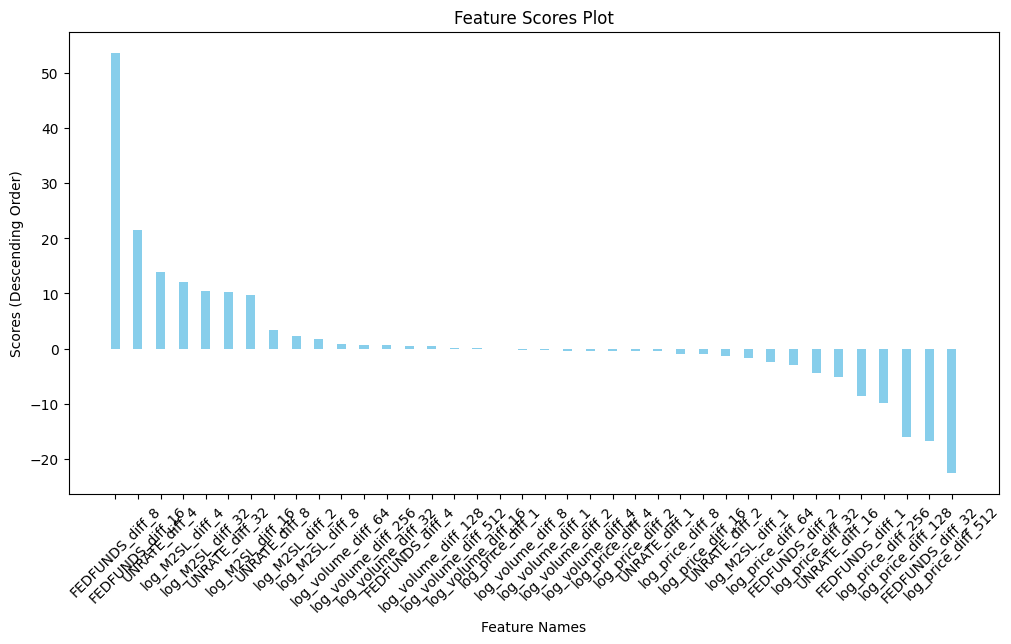

In [16]:
import matplotlib.pyplot as plt



# Assuming selector.scores_ is the array of scores for each feature
scores = coefficients

# Get the scores in descending order
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
sorted_features = feature_names[sorted_scores]
sorted_scores = scores[sorted_scores]

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_scores, color='skyblue',width=0.4)
plt.xlabel('Feature Names')
plt.ylabel('Scores (Descending Order)')
plt.title('Feature Scores Plot')
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.show()

In [ ]:



# Iterate through the stocks and select the best features for each
tot_scores = None
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    # Filter the training and testing data for the current stock
    df_train_X_stock = df_train_X_all[i]
    df_train_y_stock = df_train_y_all[i]

    # scale the features
    scaler = StandardScaler()
    df_train_X_stock = scaler.fit_transform(df_train_X_stock)

    # Apply feature selection using SelectKBest
    selector = SelectKBest(f_regression, k=5)  # Select 5 best features
    X_new = selector.fit_transform(df_train_X_stock, df_train_y_stock['log_predict'])

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_new, df_train_y_stock['log_predict'])

    scores = selector.scores_

    # make element-wise addition for tot_scores
    if tot_scores is None:
        tot_scores = scores/len(valid_tickers)
    else:
        tot_scores += scores/len(valid_tickers)

# Get the scores in descending order
feature_names = df_train_X_all[0].columns
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
sorted_features = feature_names[sorted_scores]



In [8]:
# Based on 

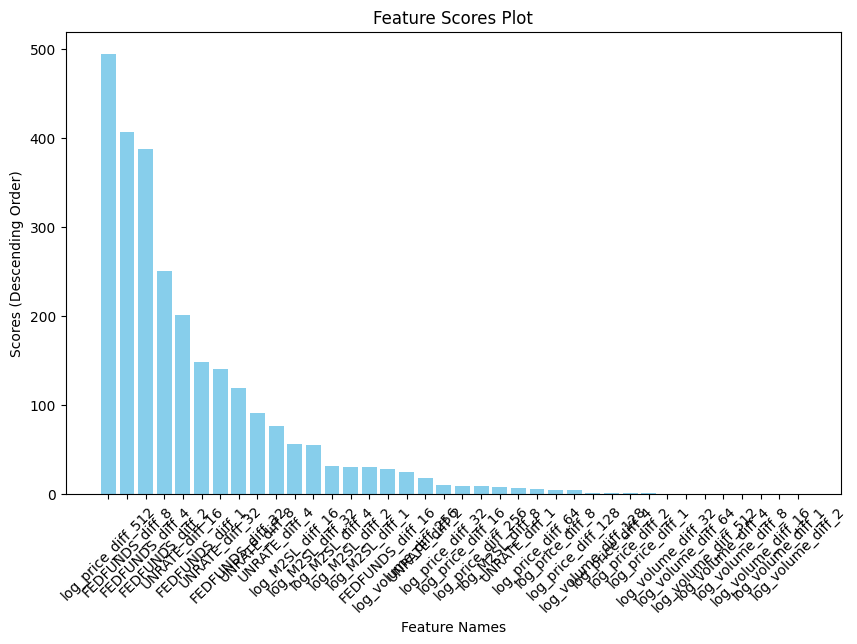

In [16]:
import matplotlib.pyplot as plt

# Assuming X_train is a DataFrame or pandas Series with feature_names
feature_names = df_train_X_all[0].columns

# Assuming selector.scores_ is the array of scores for each feature
scores = selector.scores_

# Get the scores in descending order
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
sorted_features = feature_names[sorted_scores]
sorted_scores = scores[sorted_scores]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_scores, color='skyblue')
plt.xlabel('Feature Names')
plt.ylabel('Scores (Descending Order)')
plt.title('Feature Scores Plot')
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.show()



In [1]:
sorted_features

NameError: name 'sorted_features' is not defined

In [12]:
# Get the scores in descending order
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
sorted_features = df_train_X_stock.columns[sorted_scores]
print(sorted_features)

# iterate all tickers, reorder the features based on the scores by descending order
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    df_train_X_all[i] = df_train_X_all[i][sorted_features]



    # Now you have `selected_features_train` and `selected_features_test` which contain the selected features for the current stock.
    # You can continue with training or any further processing here

Index(['log_price_diff_512', 'FEDFUNDS_diff_8', 'FEDFUNDS_diff_4',
       'FEDFUNDS_diff_2', 'UNRATE_diff_16', 'FEDFUNDS_diff_1',
       'UNRATE_diff_32', 'FEDFUNDS_diff_32', 'UNRATE_diff_8', 'UNRATE_diff_4',
       'log_M2SL_diff_16', 'log_M2SL_diff_32', 'log_M2SL_diff_4',
       'log_M2SL_diff_2', 'log_M2SL_diff_1', 'FEDFUNDS_diff_16',
       'log_volume_diff_256', 'UNRATE_diff_2', 'log_price_diff_32',
       'log_price_diff_16', 'log_price_diff_256', 'log_M2SL_diff_8',
       'UNRATE_diff_1', 'log_price_diff_64', 'log_price_diff_8',
       'log_price_diff_128', 'log_volume_diff_128', 'log_price_diff_4',
       'log_price_diff_2', 'log_price_diff_1', 'log_volume_diff_32',
       'log_volume_diff_64', 'log_volume_diff_512', 'log_volume_diff_4',
       'log_volume_diff_8', 'log_volume_diff_16', 'log_volume_diff_1',
       'log_volume_diff_2'],
      dtype='object')


In [13]:
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    # Filter the training and testing data for the current stock
    df_train_X_stock = df_train_X_all[i]
    print(df_train_X_stock.columns)


Index(['log_price_diff_512', 'FEDFUNDS_diff_8', 'FEDFUNDS_diff_4',
       'FEDFUNDS_diff_2', 'UNRATE_diff_16', 'FEDFUNDS_diff_1',
       'UNRATE_diff_32', 'FEDFUNDS_diff_32', 'UNRATE_diff_8', 'UNRATE_diff_4',
       'log_M2SL_diff_16', 'log_M2SL_diff_32', 'log_M2SL_diff_4',
       'log_M2SL_diff_2', 'log_M2SL_diff_1', 'FEDFUNDS_diff_16',
       'log_volume_diff_256', 'UNRATE_diff_2', 'log_price_diff_32',
       'log_price_diff_16', 'log_price_diff_256', 'log_M2SL_diff_8',
       'UNRATE_diff_1', 'log_price_diff_64', 'log_price_diff_8',
       'log_price_diff_128', 'log_volume_diff_128', 'log_price_diff_4',
       'log_price_diff_2', 'log_price_diff_1', 'log_volume_diff_32',
       'log_volume_diff_64', 'log_volume_diff_512', 'log_volume_diff_4',
       'log_volume_diff_8', 'log_volume_diff_16', 'log_volume_diff_1',
       'log_volume_diff_2'],
      dtype='object')
Index(['log_price_diff_512', 'FEDFUNDS_diff_8', 'FEDFUNDS_diff_4',
       'FEDFUNDS_diff_2', 'UNRATE_diff_16', 'FEDFUNDS_d